In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data/metrics.csv")
# df = pd.read_csv("data/antlr4.csv")
# df = pd.read_csv("data/discord4j.csv")
# df = pd.read_csv("data/junit4.csv")
df.head()

,Project,ID,Name,LongName,Parent,Component,Path,Line,Column,EndLine,...,Documentation Metric Rules,Documentation Rules,Error Prone Rules,Inheritance Metric Rules,Multithreading Rules,Performance Rules,Security Rules,Size Metric Rules,isDefective,Unnamed: 92
0,antlr4,L134,Tool,org.antlr.v4.Tool,L500,L103,C:\Users\domco\Desktop\DP\repos\antlr4\tool\sr...,89,1,859,...,80,0,4,0,0,18,0,21,1,NaN
1,antlr4,L125,Antlr4ErrorLog,org.antlr.mojo.antlr4.Antlr4ErrorLog,L107,L103,C:\Users\domco\Desktop\DP\repos\antlr4\antlr4-...,47,1,124,...,0,0,0,0,0,0,0,0,0,NaN
2,antlr4,L199,Antlr4Mojo,org.antlr.mojo.antlr4.Antlr4Mojo,L107,L103,C:\Users\domco\Desktop\DP\repos\antlr4\antlr4-...,77,1,505,...,26,0,2,0,0,1,0,10,0,NaN
3,antlr4,L643,ANTLRFileStream,org.antlr.v4.runtime.ANTLRFileStream,L507,L103,C:\Users\domco\Desktop\DP\repos\antlr4\runtime...,42,1,86,...,11,0,1,0,0,1,0,2,0,NaN
4,antlr4,L645,ANTLRInputStream,org.antlr.v4.runtime.ANTLRInputStream,L507,L103,C:\Users\domco\Desktop\DP\repos\antlr4\runtime...,47,1,246,...,33,2,0,0,0,1,0,7,0,NaN


## Take the working set of reatures
NOA: Number of Attributes <br>
NOP: Number of Parameters <br>
NOC: Number of Children <br>
CBO: Coupling Between Objects <br>
DIT: Depth Inheritance Tree <br>
RFC: Response for a Class <br>
LCOM5: Lack of Cohesion of Methods <br>
<i>Labels</i><br>
LOC: Line of Code <br>

In [3]:
# Labels are the values we want to predict
labels = np.array(df['LOC'])

# Remove the labels from the working dataset
features = df[['NOA', 'NOP', 'NOC', 'CBO', 'DIT', 'RFC', 'LCOM5']]

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [4]:
# Split the data into training and testing set
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=42) 

# Quick sanity check with the shapes of Training and testing datasets
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1679, 7)
Training Labels Shape: (1679,)
Testing Features Shape: (720, 7)
Testing Labels Shape: (720,)


## Traine model

In [5]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

## Make prediction

In [6]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'LOC')

Mean Absolute Error: 24.26 LOC


## Finding the accuracy of the model
Using the Mean Absolute Percentage Error (MAPE)

In [7]:
# Calculate mean absolute percentage error (MAPE)
MAPE = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(MAPE)
print('Accuracy:', round(accuracy, 2), '%')

Accuracy: 51.3 %


## Features importance

In [8]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: RFC                  Importance: 0.84
Variable: CBO                  Importance: 0.09
Variable: LCOM5                Importance: 0.04
Variable: NOA                  Importance: 0.02
Variable: NOP                  Importance: 0.01
Variable: NOC                  Importance: 0.01
Variable: DIT                  Importance: 0.01


<AxesSubplot:>

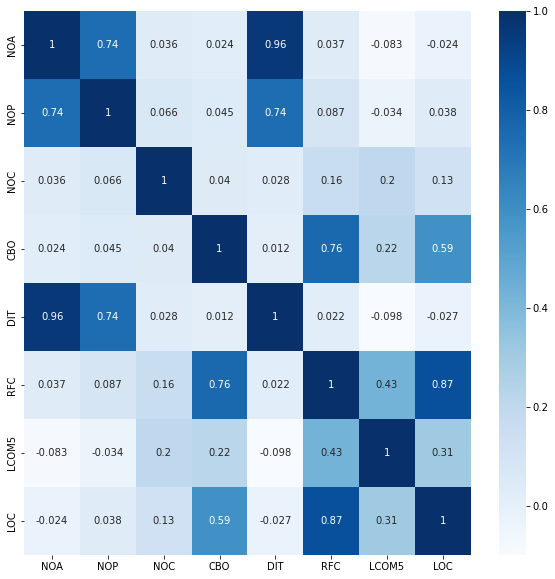

In [9]:
wdf = df[['NOA', 'NOP', 'NOC', 'CBO', 'DIT', 'RFC', 'LCOM5', 'LOC']]

# Pairwise correlations
plt.figure(figsize=(10,10))
sns.heatmap(wdf.corr(), cbar=True, annot=True, cmap='Blues')

In [10]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('RFC'), feature_list.index('CBO')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'LOC.')
MAPE = np.mean(100 * (errors / test_labels))
accuracy = 100 - MAPE
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 26.18 LOC.
Accuracy: 40.64 %.
